In [2]:
# 以下のスライドを元に実践する
# https://speakerdeck.com/s1ok69oo/dowhytoeconmlniyoruyin-guo-tui-lun-noshi-zhuang

In [3]:
from dowhy import CausalModel
import dowhy.datasets
from IPython.display import display, Image
import numpy as np
import pandas as pd

In [4]:
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_effect_modifiers=1,
    num_samples=5000,
    treatment_is_binary=1,
    stddev_treatment_noise=10,
    num_discrete_common_causes=1
)

df = data['df']
display(df.head())
display(data['dot_graph'])

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,-0.478344,0.0,0.684464,-0.120844,0.813543,0.906258,0.225694,3,True,18.597973
1,-1.648328,0.0,0.822122,0.304951,-0.312677,0.162730,2.251289,0,True,9.577913
2,-0.773194,1.0,0.324217,-1.391865,-1.579575,-1.027866,1.988844,3,True,9.724785
3,1.088756,0.0,0.750512,-0.161479,0.428438,-0.560133,0.064360,0,True,14.541545
4,-0.234723,0.0,0.324163,-1.273356,-1.428525,-0.102959,-1.178899,2,False,-6.088085


'digraph {v0->y;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}'

In [8]:
# v0が処置変数、yがアウトカム
print(data['treatment_name'])
print(data['outcome_name'])

# Z0、Z1 (操作変数) は処置に影響する
# X0 (アウトカム予測子) はアウトカムに影響する
# W0〜W4 (交絡因子) は処置とアウトカムの両方に影響する

['v0']
y


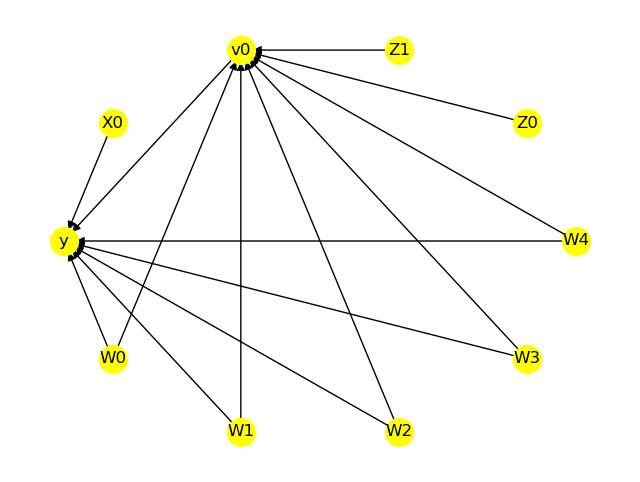

In [16]:
model = CausalModel(
    data=df,
    treatment=data['treatment_name'],
    outcome=data['outcome_name'],
    graph=data['gml_graph']
)

model.view_model()

In [17]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W0,W4,W1,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W4,W1,W3,U) = P(y|v0,W2,W0,W4,W1,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [18]:
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name='backdoor.propensity_score_matching'
)

print(causal_estimate)

propensity_score_matching


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W0,W4,W1,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W4,W1,W3,U) = P(y|v0,W2,W0,W4,W1,W3)

## Realized estimand
b: y~v0+W2+W0+W4+W1+W3
Target units: ate

## Estimate
Mean value: 10.531680345547798



In [19]:
res_random = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name='random_common_cause'
)

print(res_random)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Refute: Add a random common cause
Estimated effect:10.531680345547798
New effect:10.58007452110611
p value:0.52

